In [48]:
pip install torchvision

In [49]:
pip install opendatasets

In [50]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!ls ~/.kaggle

kaggle.json


In [51]:
!pip install torch_lr_finder

In [52]:
from torchvision import models
import torch
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

import opendatasets as od
import pathlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import torch.optim as optim

In [53]:
# od.download('https://www.kaggle.com/puneet6060/intel-image-classification')

In [54]:
od.download('https://www.kaggle.com/zalando-research/fashionmnist')

Skipping, found downloaded files in "./fashionmnist" (use force=True to force download)


In [55]:
class data(Dataset):
    def __init__(self, file_path,transform):
        df = pd.read_csv(file_path)
        self.transform = transform
        if len(df.columns) == 784:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
    
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.transform(self.X[idx])
        else:
            return self.transform(self.X[idx]) , self.y[idx]  

In [56]:
# Data transforms (normalization & data augmentation)

stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
img_size = 128
train_tfms = tt.Compose([tt.Resize((img_size,img_size)),
                         tt.RandomCrop(img_size, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),                         
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((img_size, img_size)), tt.ToTensor(), tt.Normalize(*stats)])
#data_dir = pathlib.Path('/content/intel-image-classification')
# PyTorch datasets
# train_ds = ImageFolder('/content/intel-image-classification'+'/seg_train/seg_train', train_tfms)
# valid_ds = ImageFolder('/content/intel-image-classification'+'/seg_test/seg_test', valid_tfms)

# train_ds = ImageFolder('/content/fashionmnist/fashion-mnist_train.csv', transforms.Compose([
#                            transforms.ToPILImage(),
#                            transforms.RandomRotation(5),
#                            transforms.RandomHorizontalFlip(0.5),
#                            transforms.RandomCrop(32, padding = 2),
#                            transforms.ToTensor(),
#                      transforms.Normalize(mean=(0.5,), std=(0.5,))
                       
#                        ]))
# valid_ds = ImageFolder('/content/fashionmnist/fashion-mnist_test.csv', transforms.Compose([
#                      transforms.ToPILImage(),
#                            transforms.ToTensor(),
#                      transforms.Normalize(mean=(0.5,), std=(0.5,))
#                        ])
#                 )


train_ds = data('/content/fashionmnist/fashion-mnist_train.csv',transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       
                       ])
                )
test_ds = data('/content/fashionmnist/fashion-mnist_test.csv', transforms.Compose([
                     transforms.ToPILImage(),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ])
                )
batch_size = 128

validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_ds)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_dl= torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                                sampler=valid_sampler)



# PyTorch data loaders
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
# valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [57]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
       

In [58]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device),labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        #print(labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device),labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
            
 # --------------------------------------------------------------------------#
 
from torchvision import models

class MyModel(ImageClassificationBase):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x
    # def __init__(self, num_classes , pretrained=True):
    #     super().__init__()

    #     # Use a pretrained model vgg16()
    #     self.network = models.vgg11_bn(pretrained=pretrained)
    #     # Replace last layer
    #     #self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
    #     self.network.classifier[6] = nn.Linear(self.network.classifier[6].in_features, num_classes)
        
    # def forward(self, xb):
    #     return self.network(xb)

In [59]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# def fit(epochs, lr, model, train_loader, val_loader):
#    # opt_func=torch.optim.Adam(model.parameters(), lr=0.001)
#     history = []
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1.83E-04)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=1.83E-04)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [60]:
mymodel = MyModel(10)

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
mymodel.to(device)

cuda


MyModel(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.59E-03


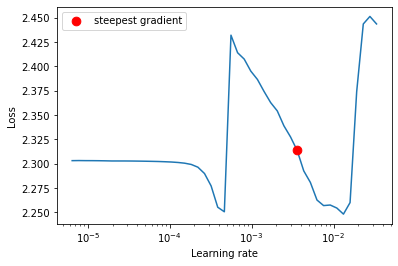

In [62]:
from torch_lr_finder import LRFinder

model = mymodel
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [63]:
epochs = 10
lr = 4.04E-04

In [64]:
history1 = fit(epochs,lr,mymodel,train_dl,valid_dl)


Epoch [0], train_loss: 0.7136, val_loss: 0.4629, val_acc: 0.8301



Epoch [1], train_loss: 0.4165, val_loss: 0.3594, val_acc: 0.8651



Epoch [2], train_loss: 0.3503, val_loss: 0.3174, val_acc: 0.8793



Epoch [3], train_loss: 0.3120, val_loss: 0.2855, val_acc: 0.8930



Epoch [4], train_loss: 0.2905, val_loss: 0.2718, val_acc: 0.9017



Epoch [5], train_loss: 0.2687, val_loss: 0.2537, val_acc: 0.9064



Epoch [6], train_loss: 0.2547, val_loss: 0.2477, val_acc: 0.9097



Epoch [7], train_loss: 0.2413, val_loss: 0.2393, val_acc: 0.9130



Epoch [8], train_loss: 0.2283, val_loss: 0.2364, val_acc: 0.9136



Epoch [9], train_loss: 0.2200, val_loss: 0.2503, val_acc: 0.9100


In [65]:
print(history1)

[{'val_loss': 0.46285438537597656, 'val_acc': 0.8300642371177673, 'train_loss': 0.7136256694793701}, {'val_loss': 0.35938432812690735, 'val_acc': 0.8650542497634888, 'train_loss': 0.41649389266967773}, {'val_loss': 0.31736791133880615, 'val_acc': 0.8793494701385498, 'train_loss': 0.3503228425979614}, {'val_loss': 0.2855437695980072, 'val_acc': 0.8929521441459656, 'train_loss': 0.3119961619377136}, {'val_loss': 0.2718254625797272, 'val_acc': 0.9017342925071716, 'train_loss': 0.2904545068740845}, {'val_loss': 0.2537309229373932, 'val_acc': 0.906388521194458, 'train_loss': 0.2687146067619324}, {'val_loss': 0.24773269891738892, 'val_acc': 0.9096575975418091, 'train_loss': 0.25465482473373413}, {'val_loss': 0.23933616280555725, 'val_acc': 0.9129820466041565, 'train_loss': 0.2412521094083786}, {'val_loss': 0.2364019751548767, 'val_acc': 0.9135915040969849, 'train_loss': 0.22831131517887115}, {'val_loss': 0.2503040134906769, 'val_acc': 0.9099623560905457, 'train_loss': 0.2199775129556656}]


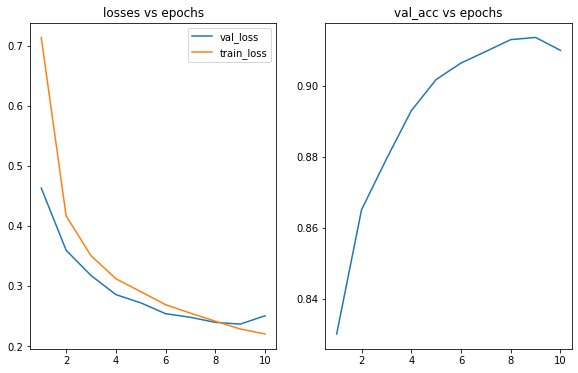

In [66]:
li1 = []
li2 = []
li3 = []
for dict1 in history1:
    li1.append(dict1["val_loss"])
    li2.append(dict1["val_acc"])
    li3.append(dict1["train_loss"])

fig =plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(range(1,epochs+1), li1)
plt.plot(range(1,epochs+1), li3)
plt.title("losses vs epochs")
plt.legend(["val_loss","train_loss"])


plt.subplot(1, 3, 2)
plt.plot(range(1,epochs+1), li2)
plt.title("val_acc vs epochs")

plt.show()

In [67]:
epoch2 = 10
lr = 4.04E-04

In [68]:
history2 = fit_one_cycle(epoch2,lr,mymodel,train_dl,valid_dl)


Epoch [0],last_lr: 0.00011, train_loss: 0.1872, val_loss: 0.2177, val_acc: 0.9200



Epoch [1],last_lr: 0.00031, train_loss: 0.2165, val_loss: 0.2502, val_acc: 0.9052



Epoch [2],last_lr: 0.00040, train_loss: 0.2441, val_loss: 0.2753, val_acc: 0.9000



Epoch [3],last_lr: 0.00038, train_loss: 0.2413, val_loss: 0.2350, val_acc: 0.9156



Epoch [4],last_lr: 0.00033, train_loss: 0.2159, val_loss: 0.2266, val_acc: 0.9180



Epoch [5],last_lr: 0.00025, train_loss: 0.1929, val_loss: 0.2294, val_acc: 0.9174



Epoch [6],last_lr: 0.00016, train_loss: 0.1700, val_loss: 0.2094, val_acc: 0.9257



Epoch [7],last_lr: 0.00008, train_loss: 0.1452, val_loss: 0.2031, val_acc: 0.9304



Epoch [8],last_lr: 0.00002, train_loss: 0.1251, val_loss: 0.2053, val_acc: 0.9304



Epoch [9],last_lr: 0.00000, train_loss: 0.1125, val_loss: 0.2002, val_acc: 0.9316


In [69]:
print(history2)

[{'val_loss': 0.21770820021629333, 'val_acc': 0.9200188517570496, 'train_loss': 0.18715828657150269, 'lrs': [1.615999999999998e-05, 1.616075745955258e-05, 1.616302983229313e-05, 1.6166817100469555e-05, 1.617211923449544e-05, 1.617893619295014e-05, 1.618726792257895e-05, 1.619711435829369e-05, 1.6208475423173246e-05, 1.6221351028463966e-05, 1.623574107358067e-05, 1.6251645446106993e-05, 1.6269064021796724e-05, 1.6287996664574576e-05, 1.6308443226536995e-05, 1.6330403547953952e-05, 1.6353877457269534e-05, 1.637886477110352e-05, 1.640536529425306e-05, 1.6433378819693818e-05, 1.646290512858175e-05, 1.6493943990254962e-05, 1.6526495162235376e-05, 1.656055839023042e-05, 1.6596133408135303e-05, 1.663321993803518e-05, 1.6671817690206835e-05, 1.6711926363121557e-05, 1.6753545643447085e-05, 1.6796675206050054e-05, 1.684131471399881e-05, 1.6887463818565846e-05, 1.6935122159230417e-05, 1.6984289363681723e-05, 1.7034965047821467e-05, 1.7087148815766995e-05, 1.714084025985444e-05, 1.7196038960641655

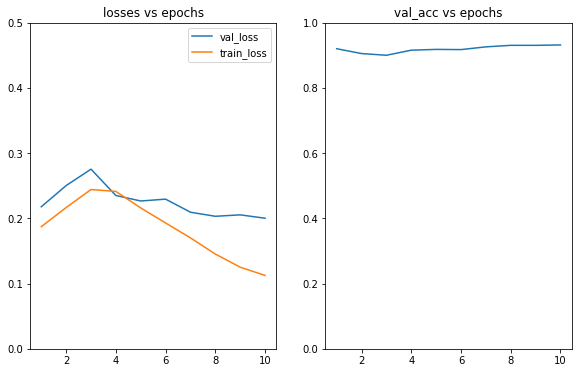

In [70]:
li1 = []
li2 = []
li3 = []
for dict1 in history2:
    li1.append(dict1["val_loss"])
    li2.append(dict1["val_acc"])
    li3.append(dict1["train_loss"])

fig =plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(range(1,10+1), li1)
plt.plot(range(1,10+1), li3)
plt.ylim(0, 0.5)
plt.title("losses vs epochs")
plt.legend(["val_loss","train_loss"])


plt.subplot(1, 3, 2)
plt.plot(range(1,10+1), li2)
plt.ylim(0, 1)
plt.title("val_acc vs epochs")

plt.show()